# **Ruido Gaussiano y Ancho de Banda**

# Importar módulos

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.signal import lfilter, correlate, welch
from scipy.stats import norm
from IPython.display import HTML

# Código base

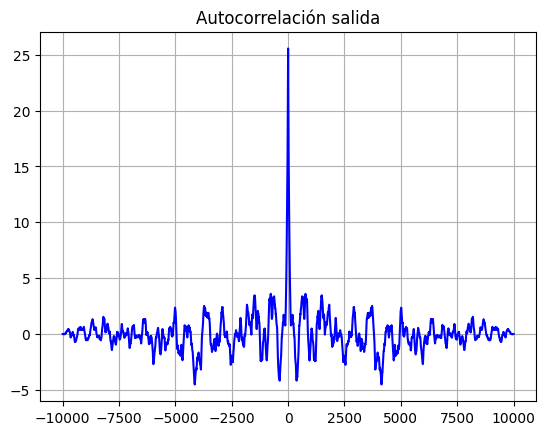

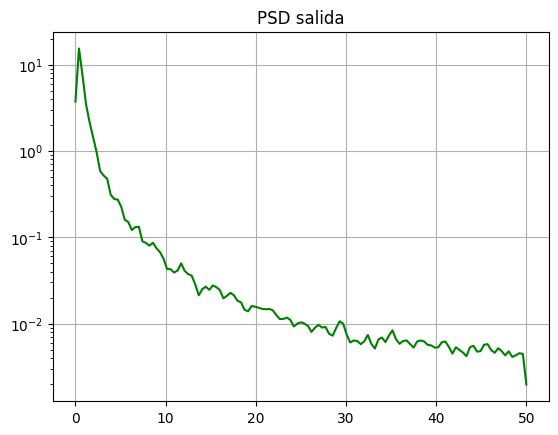

In [2]:
# Código base tomado del documento: Taller 2. Parte 2: Procesos aleatorios, ruido gaussiano y transmisión a través de sistemas LTI.
A = 10000
a = 2
G = 3
x = np.random.normal(0, 1, A) # Señal de AWGN mu=0, sigma=1
t = np.arange(0, 10, 0.01)
h = np.exp(-a*t)
y = lfilter(h, [1], x)
autocorr = correlate(y, y, mode='full') / A
lags = np.arange(-A + 1, A)
f, Pxx = welch(y, fs=100)

plt.figure()
plt.plot(lags, autocorr,color='b')
plt.grid(True)
plt.title("Autocorrelación salida")

plt.figure()
plt.semilogy(f, Pxx,c='g')
plt.title("PSD salida")
plt.grid(True)
plt.show()

# **Algoritmo de convolución recursiva y cálculo de la varianza**

In [3]:
def conv_recursiva(h, iter):
  """
Aplica convoluciones recursivas a una señal consigo misma.

Parámetros:
- h: señal de entrada, representada como un arreglo unidimensional de coeficientes.
- iter: número de veces que se aplica la convolución recursiva.

Retorna:
- Una tupla con:
- h_final: resultado de la última convolución recursiva.
- h_history: lista con todos los resultados intermedios de cada iteración de convolución.
  """
  h_history = [h.copy()]
  for i in range(1, iter):
      h_new = np.convolve(h_history[-1], h)
      h_history.append(h_new)
  h_final = h_history[-1]
  return h_final, h_history

def animar_convolucion(h_history, intervalo=500):
    """
    Genera una animación que muestra la evolución de una convolución recursiva
    a lo largo de múltiples iteraciones.

    Parámetros:
      h_history : lista que contiene la evolución de la señal convolucionada.
      Cada elementorepresenta el estado de la señal en una iteración.
      intervalo : tiempo en milisegundos entre cada fotograma de la animación.

    Retorna:
      IPython.display.HTML: Objeto HTML con la animación embebida en formato JavaScript, ideal para Jupyter notebooks.
    """
    plt.close('all')
    fig, ax = plt.subplots()

    line, = ax.plot([], [], lw=3)
    ax.set_xlabel('Índice de muestra')
    ax.set_ylabel('Amplitud')
    ax.set_title('Evolución de la Convolución Recursiva')

    max_len = max(len(h) for h in h_history)
    max_val = max(np.max(np.abs(h)) for h in h_history)
    ax.set_xlim(0, max_len)
    ax.set_ylim(0, 1.1 * max_val)
    ax.grid(True)

    colores = plt.cm.jet(np.linspace(0, 1, len(h_history)))
    texto_iteracion = ax.text(0.95, 0.95, '', transform=ax.transAxes,
                              ha='right', va='top', fontsize=12,
                              bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='black'))

    def init():
        line.set_data([], [])
        texto_iteracion.set_text('')
        return line, texto_iteracion

    def update(frame):
        y = h_history[frame]
        x = np.arange(len(y))
        line.set_data(x, y)
        line.set_color(colores[frame])
        line.set_linewidth(2)
        texto_iteracion.set_text(f'Iteración {frame + 1}')
        return line, texto_iteracion

    ani = FuncAnimation(fig, update, frames=len(h_history), init_func=init,
                        blit=False, interval=intervalo, repeat=False)
    plt.close(fig)
    return HTML(ani.to_jshtml())

In [4]:
# Solución primer ítem
# Definición de parámaetros
A = 10000
a = 2
G = 3
x = np.random.normal(0, 1, A) # Señal de AWGN mu=0, sigma=1
N = 10 + G # Número de muestras de la ventana cuadrada
iter = 20 # Número de iteraciones convolución recursiva
h = np.ones(N) / N  # Ventana cuadrada normalizada
h_rec, h_history = conv_recursiva(h, iter)
animar_convolucion(h_history)

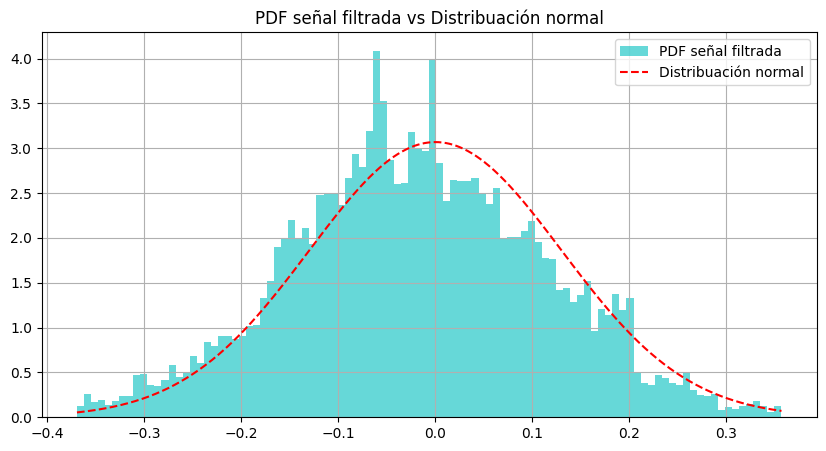

Varianza del AWGN: 0.9911392588493634
Varianza de la señal filtrada: 0.016903688418862146


In [5]:
# Solución primer ítem
y = lfilter(h_rec, [1], x)  # Señal filtrada

x_vals = np.linspace(min(y), max(y), 1000)
pdf_normal = norm.pdf(x_vals, loc=0, scale=np.sqrt(np.std(y)**2)) # Distribución normal (loc=mu, scale=sigma**2)

# Gráfico PDF señal filtrada vs Distribuación normal
plt.figure(figsize=(10, 5))
plt.hist(y, bins=100, density=True, color='c', alpha=0.6, label='PDF señal filtrada')
plt.plot(x_vals, pdf_normal, '--r', label='Distribuación normal')
plt.title("PDF señal filtrada vs Distribuación normal")
plt.grid(True)
plt.legend()
plt.show()

# Comparación entre la varianza del ruido AWGN y de la señal filtrada
print(f"Varianza del AWGN: {np.var(x)}")
print(f"Varianza de la señal filtrada: {np.var(y)}")

# **Algoritmo para calcular la densidad espectral de potencia de la señal de ruido filtrada**

In [6]:
def graficar_psd(x, y, mu, sigma, fs=100):
  """
  Grafica la densidad espectral de potencia (PSD) de una señal de ruido blanco gaussiano (AWGN),.
  sin filtrar y su versión filtrada por un sistema exponencialmente decreciente.

  Parámetros:
    x : Señal de ruido blanco gaussiano (AWGN) sin filtrar.
    y : Señal filtrada obtenida a partir de x mediante un sistema lineal.
    mu : Media de la señal de ruido blanco gaussiano.
    sigma : Desviación estándar de la señal de ruido blanco gaussiano.
    fs : Frecuencia de muestreo utilizada para el cálculo del PSD.

  Retorna:
    La función muestra las gráficas generadas.
  """
  A = 10000
  a = 2
  x = np.random.normal(mu, sigma, A) # Señal de AWGN mu=0, sigma=1
  t = np.arange(0, 10, 0.01)
  h = np.exp(-a*t)
  y = lfilter(h, [1], x)
  lags = np.arange(-A + 1, A)

  lags = np.arange(-A + 1, A)
  f_r, Pxx_r = welch(x, fs= 100)
  f_y, Pxx_y = welch(y, fs=100)

  plt.figure()
  plt.semilogy(f_y, Pxx_y, 'c', label='PSD señal de ruido filtrada')
  plt.semilogy(f_r, Pxx_r, 'g', label='PSD señal de ruido sin filtrar')
  plt.title("Densidad espectral")
  plt.xlabel("Frecuencia [Hz]")
  plt.ylabel("Amplitud")
  plt.legend()
  plt.grid(True)
  plt.show()

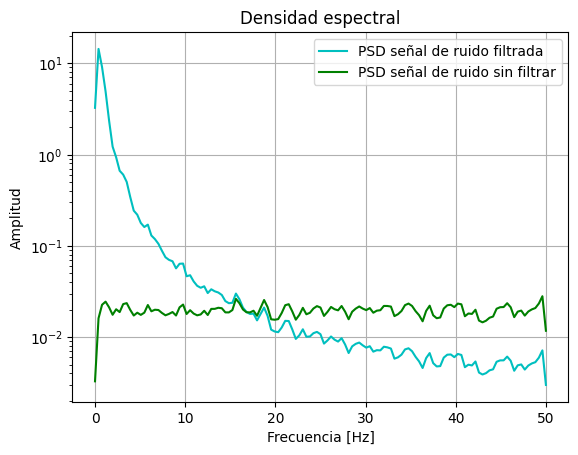

In [7]:
# Solución segundo ítem
# Definición de parámaetros
A = 10000
a = 2
G = 3
x = np.random.normal(0, 1, A) # Señal de AWGN mu=0, sigma=1
N = 10 + G # Número de muestras de la ventana cuadrada
iter = 25 # Número de iteraciones convolución recursiva
t = np.arange(0, 10, 0.01)
h = np.exp(-a*t)  # Filtro LIT con respuesto al impulso h

y = lfilter(h, [1], x) # Señal de salida filtrada
graficar_psd(x, y, 0, 1, 100)

# **Algoritmo para estimar la autocorrelación y densidad espectral de potencia (PSD)**

In [8]:
def graficar_autocorr_psd(mu, sigma, fs=100):
  """
  Grafica la autocorrelación y la densidad espectral de potencia (PSD) de una señal
  de ruido blanco gaussiano (AWGN) y su versión filtrada por un sistema exponencialmente
  decreciente.

  Parámetros:
    mu : Media de la señal de ruido blanco gaussiano.
    sigma : Desviación estándar de la señal de ruido blanco gaussiano.
    fs : Frecuencia de muestreo utilizada para el cálculo del PSD.

  Retorna:
    La función muestra las gráficas generadas.
  """
  A = 10000
  a = 2
  x = np.random.normal(mu, sigma, A) # Señal de AWGN mu=0, sigma=1
  t = np.arange(0, 10, 0.01)
  h = np.exp(-a*t)
  y = lfilter(h, [1], x)
  lags = np.arange(-A + 1, A)

  autocorr_x = correlate(x, x, mode='full') / A
  f2, Pxx2 = welch(x, fs)

  autocorr_y = correlate(y, y, mode='full') / A
  f1, Pxx1 = welch(y, fs)

  # Gráfico de autocorrelación
  plt.figure(figsize=(22, 4))
  plt.subplot(1, 4, 1)
  plt.plot(lags, autocorr_x,color='b')
  plt.title(f"Autocorrelación: entrada (x)")
  plt.xlabel("Frecuencia [Hz]")
  plt.ylabel("Amplitud")
  plt.subplot(1, 4, 2)
  plt.plot(lags, autocorr_y,color='c')
  plt.title(f"Autocorrelación: salida (y)")
  plt.xlabel("Frecuencia [Hz]")
  plt.subplot(1, 4, 3)
  plt.semilogy(f2, Pxx2,c='g')
  plt.title(f"PSD: Entrada (x)")
  plt.xlabel("Frecuencia [Hz]")
  plt.subplot(1, 4, 4)
  plt.semilogy(f1, Pxx1,c='purple')
  plt.title(f"PSD: Salida (y)")
  plt.xlabel("Frecuencia [Hz]")
  plt.grid(True)

  plt.suptitle(f"mu={mu}, sigma={sigma}")
  plt.show()

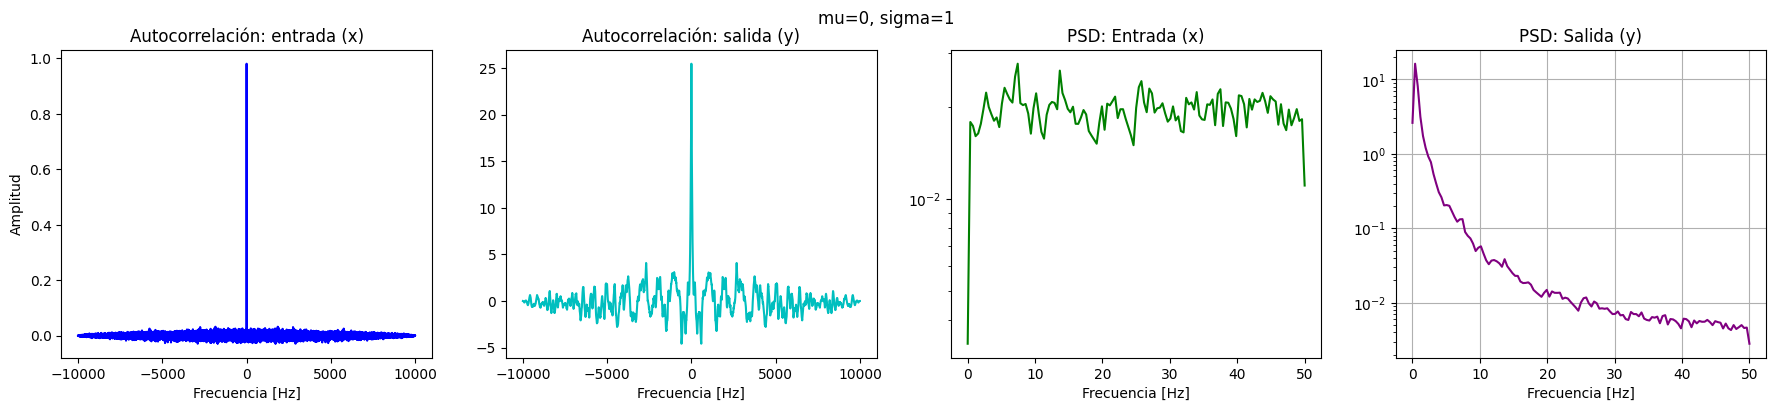

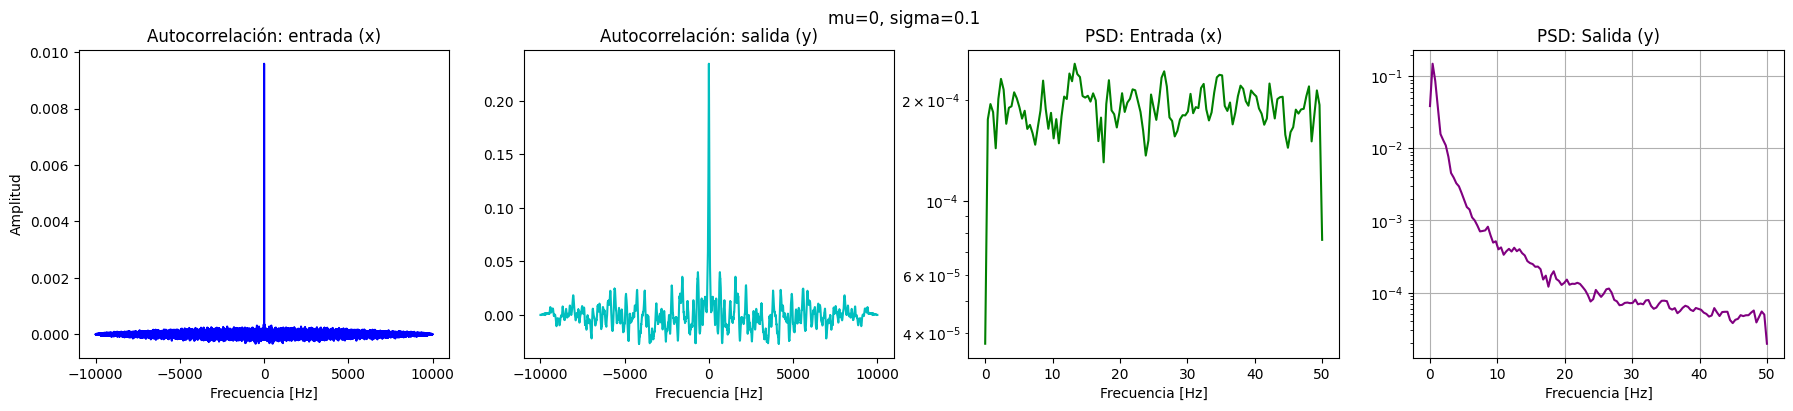

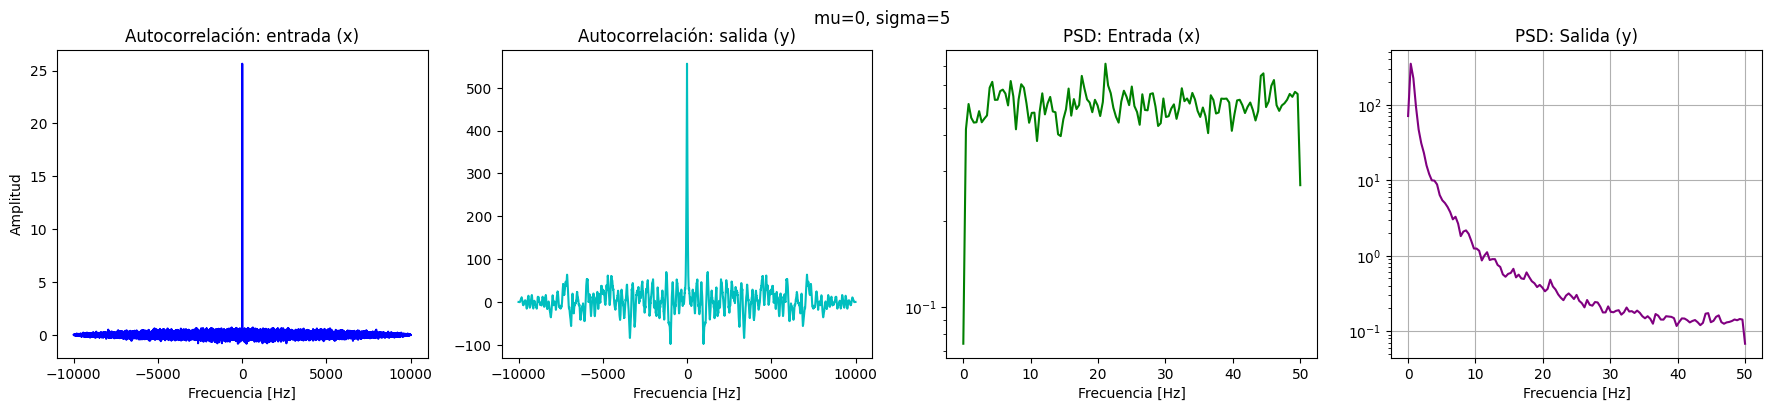

In [11]:
# Solución tercer ítem
graficar_autocorr_psd(0, 1, fs=100)
graficar_autocorr_psd(0, 0.1, fs=100)
graficar_autocorr_psd(0, 5, fs=100)

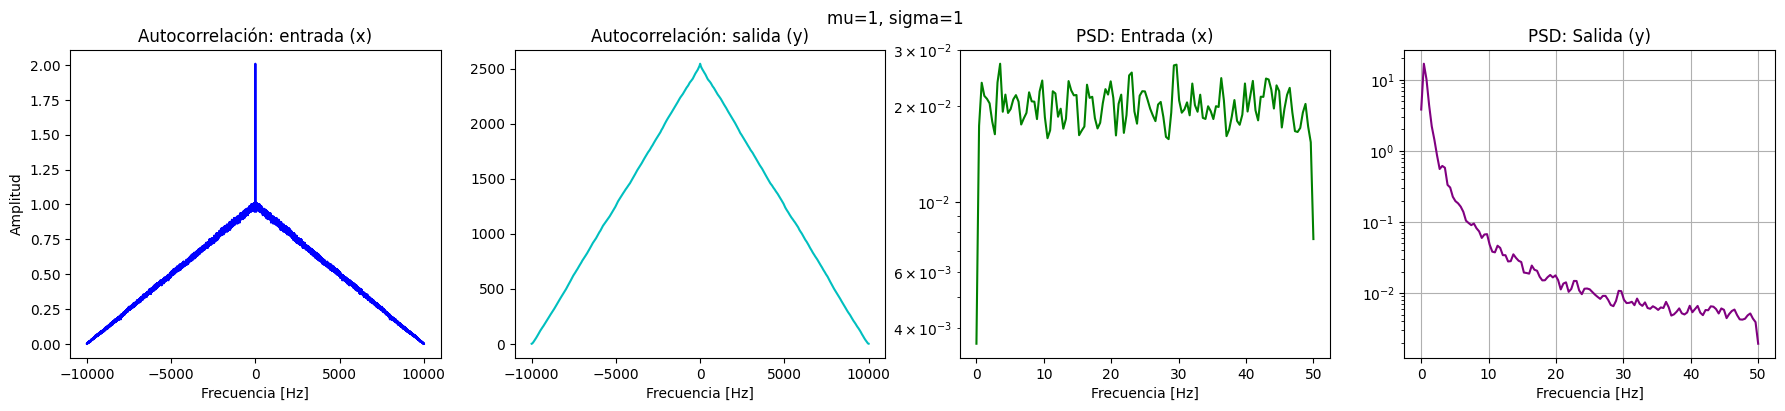

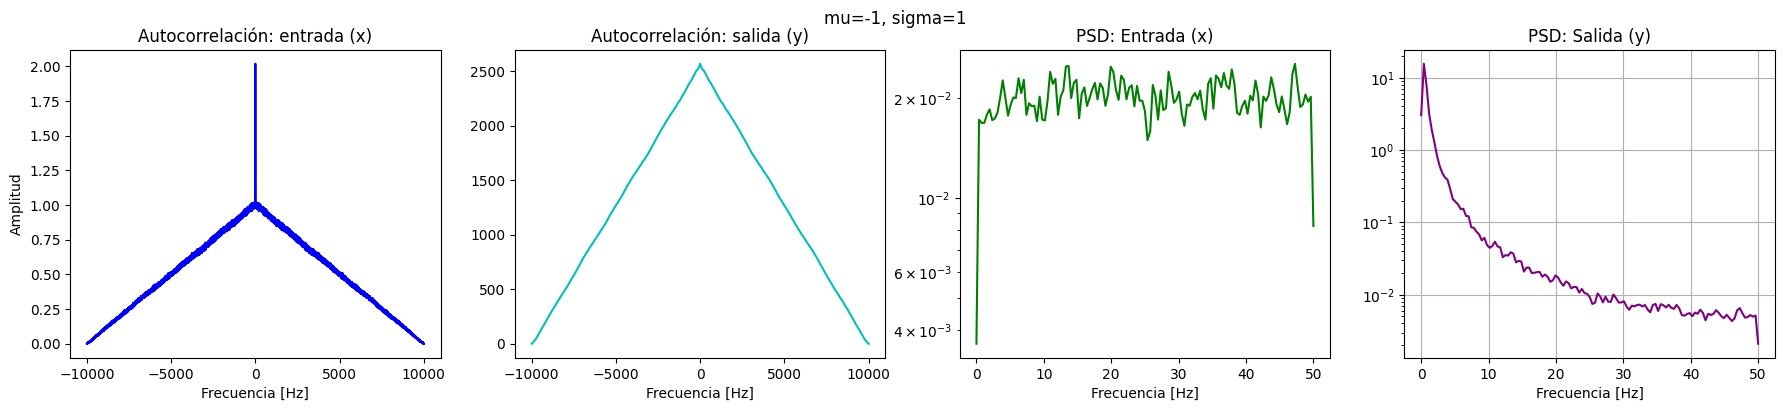

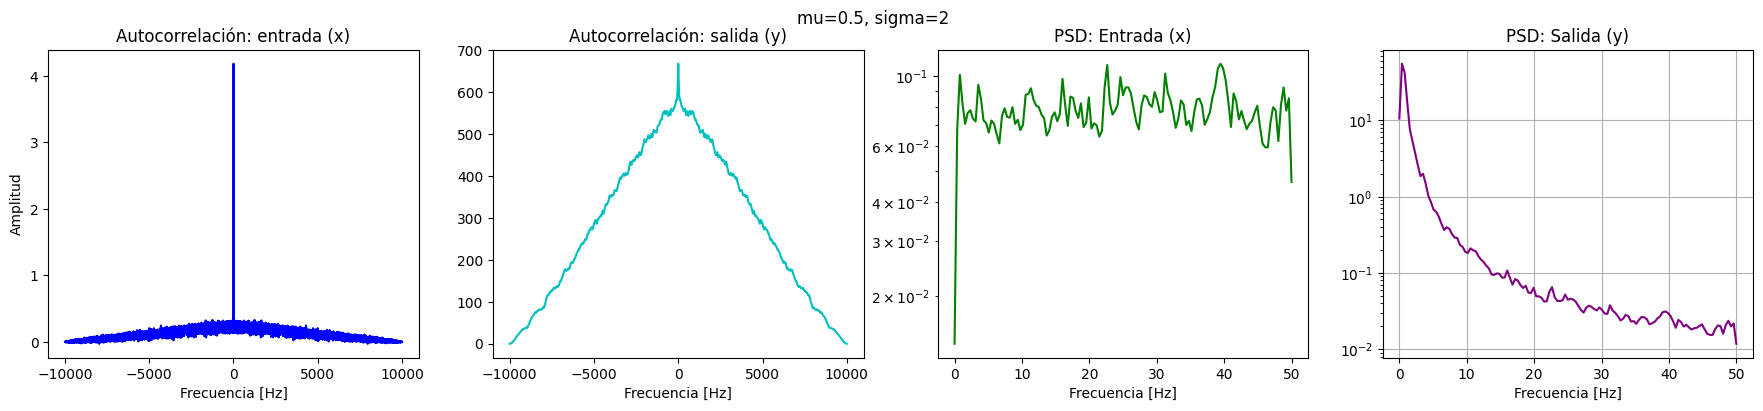

In [10]:
# Solución tercer ítem
graficar_autocorr_psd(1, 1, fs=100)
graficar_autocorr_psd(-1, 1, fs=100)
graficar_autocorr_psd(0.5, 2, fs=100)